# Metrics

## Inception Score (IS)
​
[original paper](https://arxiv.org/abs/1606.03498)
​

**Aim**: see how variate samples are

### Idea
Let's see how much classes our generative model is able to generate

![image](https://miro.medium.com/max/2976/1*X29oOi1Tzch2j6MuG9XS1Q.png)
![image](https://miro.medium.com/max/2812/1*t8lE_W4UKQ8jKgzxCAbHTA.png)

### How it works
We compare each samples classes with averaged (marginal) one. If each sample's distribution differs from common (marginal) one, then it differs from others.

![image](https://miro.medium.com/max/3472/1*hPEJY3MkOZyKFA6yEqzuyg.png)

Here KL divergence is used to calculate the distance



## Frechet Inception Distance (FID)

**Idea**: compare distributions of real and generated samples

**Algorithm**:
1. Get samples embeddings from intermediate layers of neural network pre-trained on some external dataset
2. Approximate embeddings of real and generated samples by gaussians $\mathcal{N}(\mu_1, \Sigma_1)$ and $\mathcal{N}(\mu_2, \Sigma_2)$ respectively
3. Calclulate Frecher Distance = $\|\mu_1 – \mu_2\|^2 + Tr(\Sigma_1 + \Sigma_2 - 2 * \text{sqrt}(\Sigma_1*\Sigma_2))$. The smaller the better

## Metrics summary

![](https://miro.medium.com/max/875/0*GHvXKp6DQPAHGdqH)



### Comparison

|                            Metric |                                 IS                                 | FID                                                            |
|----------------------------------:|:------------------------------------------------------------------:|----------------------------------------------------------------|
| **Aim**                               | show *how variate* generated images are                            | show *how close* generated images to real ones are             |
| Which distributions are compared? | Discrete predicted class distributions (marginal vs. sample's one) | Two continuous gaussian distributions (real vs. generated one) |
| Which data is used?               | Generated only                                                     | Generated and real                                             |
| Which distance is used?           | KL                                                                 | Frechet distance                                               |

# LPIPS (Learned Perceptual Image Similarity)
$$d_{LPIPS}(x,y)=\Sigma_l\frac{1}{H_lW_l}\Sigma_{i,j}||w_l\cdot(\hat{x}^l_{ij}-\hat{y}^l_{ij})||^2_2$$
where $\hat{x}^l_{ij}$ and $\hat{y}^l_{ij}$ denote the normalized feature vectors at layer $l$ and pixel $(i, j)$, $w_l$ contains weights for each of the features in layer $l$, and $\cdot$ multiplies the feature vectors at each pixel by the specifically learned weights

In [2]:
import torchvision
dataset = torchvision.datasets.FashionMNIST('../data/fashion_mnist', download=True)

In [3]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-ocs_97fl
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4969 sha256=9f8e16358930ac8c23ec62bb8ce154d9de273379644a59b33c79e9aa34ec325a
  Stored in directory: /tmp/pip-ephem-wheel-cache-pc6bdsga/wheels/f1/a0/8a/61a1e7ea93d2c34053dad3c582554b43882f178c31a75c3ba4
Successfully built lpips-pytorch


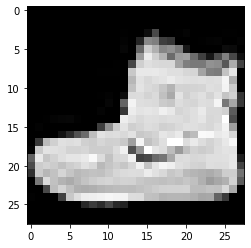

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

original_img_idx = 0
original_img, original_label = dataset[original_img_idx]
plt.imshow(original_img, cmap='gray')

### Task
Find closest image to the above one

In [5]:
from lpips_pytorch import LPIPS, lpips
from tqdm.notebook import tqdm

# define as a criterion module (recommended)
criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
)

def img2tensor(img):
    return torch.from_numpy(np.array(img.resize((512,512))))

np.random.seed(10)
img_indices = np.random.choice(np.arange(len(dataset)), 1000) # random images to be compared
img_indices = [idx for idx in img_indices if idx != original_img_idx]

distances, labels = [], []

# calculate LPIPS distances
### BEGIN SOLUTION
for idx in tqdm(img_indices):
    img, label = dataset[idx]
    labels.append(label)
    distances.append(criterion(img2tensor(original_img), img2tensor(img)).detach().cpu().squeeze().item())
### END SOLUTION

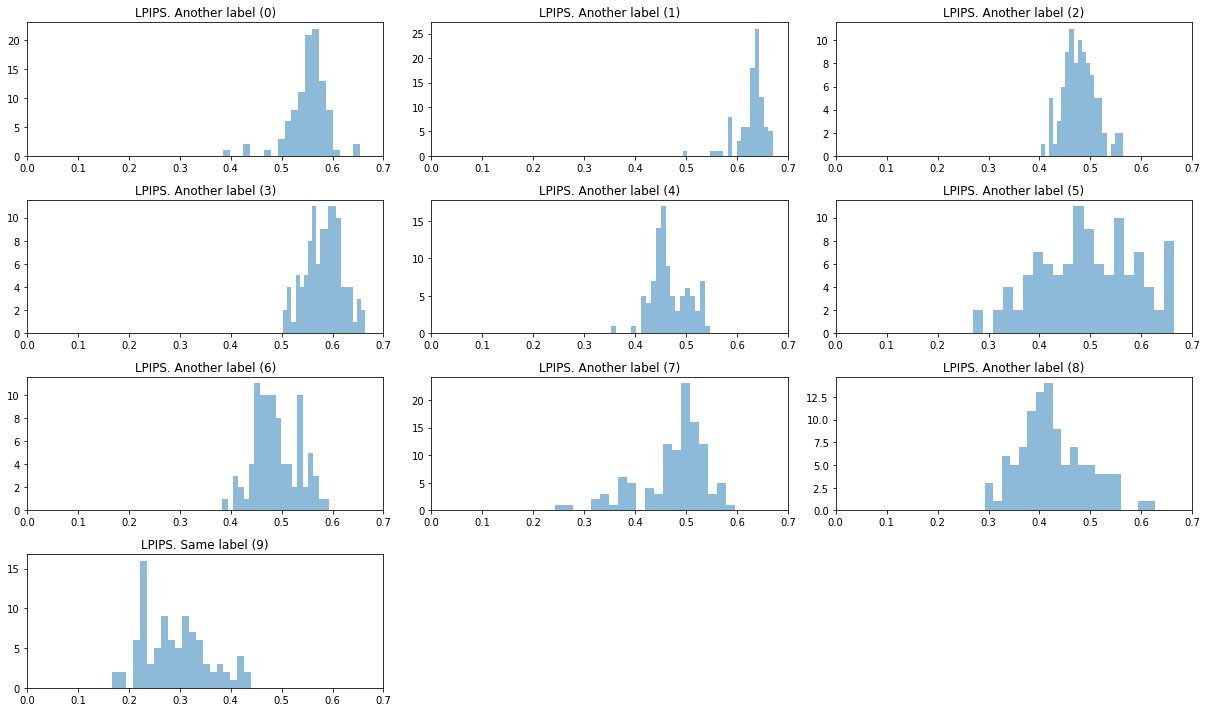

In [6]:
plt.figure(figsize=(17,10))
n_classes = 10
for label in range(n_classes):
    plt.subplot(4,3,label+1)
    plt.title(f'LPIPS. %s label (%d)' % ({True: 'Same', False: 'Another'}[label==original_label], label))
    plt.xlim((0.,0.7))
    plt.hist(np.array(distances)[np.array(labels)==label], bins=20, alpha=0.5);
plt.tight_layout();

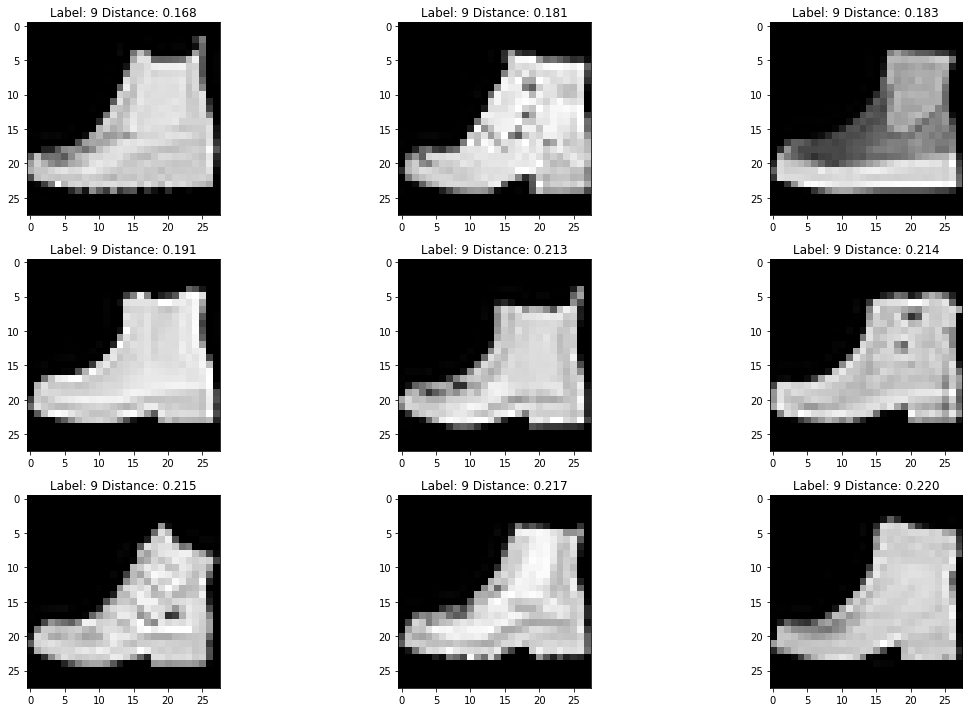

In [7]:
plt.figure(figsize=(17,10))
closest_img_cnt = 9
closest_img_indices, closest_distances, closest_labels = [
    np.array(img_indices)[np.argsort(distances)[:closest_img_cnt]], 
    np.array(distances)[np.argsort(distances)[:closest_img_cnt]], 
    np.array(labels)[np.argsort(distances)[:closest_img_cnt]]]

for ax_idx, (img_idx, distance, label) in enumerate(zip(closest_img_indices, closest_distances, closest_labels)):
    img = np.array(dataset[img_idx][0])
    plt.subplot(3,3,ax_idx+1)
    plt.title(f'Label: %d Distance: %.3f'%(label, distance))
    plt.imshow(img, cmap='gray')
plt.tight_layout();

In [8]:
### BEGIN HIDDEN TEST
assert(min(distances) < 0.2)
assert((np.array(closest_labels) == original_label).mean() > 0.9)
### END HIDDEN TEST